In [3]:
using Statistics: mean

import FFTW

using Interact
using PyPlot

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/05a54a8cd5b6d9c9183d90a9a0f9abc6032d3417-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/05a54a8cd5b6d9c9183d90a9a0f9abc6032d3417-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [54]:
@show Lx, Ly = 8, 8;
@show Nx, Ny = 128, 128;
@show Δx, Δy = Lx/Nx, Ly/Ny;
@show x = Δx * (0:(Nx-1));
@show y = Δy * (0:(Ny-1));

(Lx, Ly) = (8, 8) = (8, 8)
(Nx, Ny) = (128, 128) = (128, 128)
(Δx, Δy) = (Lx / Nx, Ly / Ny) = (0.0625, 0.0625)
x = Δx * (0:Nx - 1) = 0.0:0.0625:7.9375
y = Δy * (0:Ny - 1) = 0.0:0.0625:7.9375


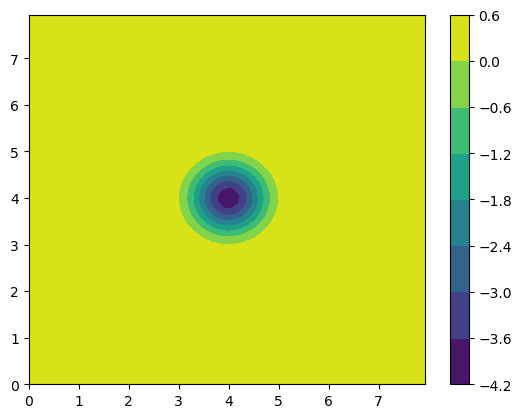

size(f) = (128, 128)
minimum(f) = -4.0
maximum(f) = 0.5413411329464508


In [55]:
# f = @. exp(- 0.1 * ( (x - Lx/2)^2 + (y - Ly/2)'^2));
x′ = @. x - Lx/2;
y′ = @. y - Ly/2;
f = @. 4 * (x′^2 + y′'^2 - 1) * exp(-(x′^2 + y′'^2))
ϕa = @. exp(-(x′^2 + y′'^2))
@show size(f);
@show minimum(f);
@show maximum(f);
PyPlot.contourf(x, y, f); PyPlot.colorbar();

In [ ]:
fh = FFTW.rfft(f)

In [ ]:
l = 0:(Nx-1)
m = 0:(Ny-1)
# kx² = @. (4 / Δx^2) * sin(π*l / Nx)^2;
# ky² = @. (4 / Δy^2) * sin(π*m / Ny)^2;
kx² = @. ((2*π / Lx) * l)^2
ky² = @. ((2*π / Ly) * m)^2

In [ ]:
# ϕh = - fh ./ k²[1:Int(Nx/2 + 1), :]; ϕh[1, 1] = 0; ϕh[1, end] = 0; ϕh
ϕh = zeros(Complex{Float64}, size(fh))
for j in 1:Ny, i in 1:Int(Nx/2)
    ϕh[i, j] = - fh[i, j] / (kx²[i] + ky²[j])
end
ϕh[1, 1] = 0; ϕh[1, end] = 0;
ϕh

In [ ]:
ϕs = FFTW.irfft(ϕh, Nx)

In [ ]:
maximum(ϕs) - minimum(ϕs)

In [ ]:
PyPlot.contourf(x, y, ϕs, levels=20); PyPlot.colorbar();

In [ ]:
PyPlot.contourf(Δx * (0:(2*Nx-1)), Δy * (0:(2*Ny-1)), vcat(hcat(ϕs, ϕs), hcat(ϕs, ϕs)) .- minimum(ϕs), levels=20); PyPlot.colorbar();

In [ ]:
fh = FFTW.fft(f)
ϕh = zeros(Complex{Float64}, size(fh))
for j in 1:Ny, i in 1:Ny
    ϕh[i, j] = - fh[i, j] / (kx²[i] + ky²[j])
end
ϕh[1,1] = 0
ϕs = FFTW.ifft(ϕh)
PyPlot.contourf(x, y, ϕs, levels=20); PyPlot.colorbar();

In [82]:
function solve_poisson_2d_pbc(f, Lx, Ly, wavenumbers=:second_order)
    Nx, Ny = size(f)  # Number of grid points (excluding the periodic end point).

    # Forward transform the real-valued source term.
    fh = FFTW.rfft(f)

    # Wavenumbers.
    # l, m = 0:Nx, 0:Ny  # Wavenumber indices.
    # kx² = @. ((2*π / Lx) * l)^2
    # ky² = @. ((2*π / Ly) * m)^2
    # ϕh = - fh ./ k²[1:Int(Nx/2 + 1), :]; ϕh[1, 1] = 0; ϕh[1, end] = 0; ϕh
    
    i1 = 0:Int(Nx/2)
    i2 = Int(-Nx/2+1):-1
    j1 = 0:Int(Ny/2)
    j2 = Int(-Ny/2+1):-1
    
    if wavenumbers == :second_order
        Δx = Lx/Nx
        Δy = Ly/Ny
        kx² = reshape((4/Δx^2) .* sin.( (π/Nx) .* cat(i1, i2, dims=1)).^2, (Nx, 1))
        ky² = reshape((4/Δy^2) .* sin.( (π/Ny) .* cat(j1, j2, dims=1)).^2, (1, Ny))
        k² = @. kx² + ky²
    elseif wavenumbers == :analytic    
        kx = reshape((2π/Lx) * cat(i1, i2, dims=1), (Nx, 1))
        ky = reshape((2π/Ly) * cat(j1, j2, dims=1), (1, Ny))
        k² = @. kx^2 + ky^2
    end
    
    ϕh = - fh ./ k²[1:Int(Nx/2 + 1), :]

    # Setting the DC/zero Fourier component to zero.
    ϕh[1, 1] = 0

    # Take the inverse transform of the solution's Fourier coefficients.
    ϕ = FFTW.irfft(ϕh, Nx)
end

solve_poisson_2d_pbc (generic function with 2 methods)

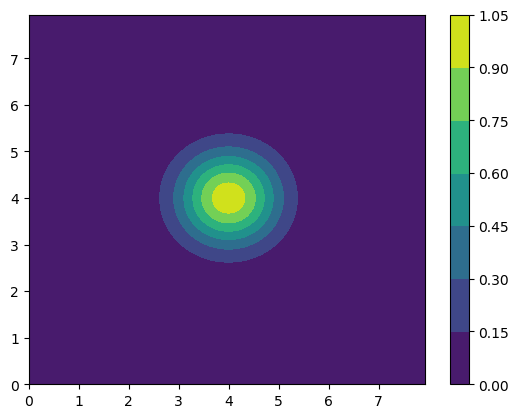

minimum(ϕs) = -0.04908752080575006
maximum(ϕs) = 0.950912423196228
minimum(ϕs) = 0.0
maximum(ϕs) = 0.9999999440019781


In [56]:
ϕs = solve_poisson_2d_pbc(f, Lx, Ly, :analytic)
@show minimum(ϕs)
@show maximum(ϕs)
ϕs = ϕs .- minimum(ϕs)
@show minimum(ϕs)
@show maximum(ϕs)
PyPlot.contourf(x, y, ϕs .- minimum(ϕs)); PyPlot.colorbar();

size(x″) = (256,)
size(y″) = (256,)
size(ϕs″) = (256, 256)

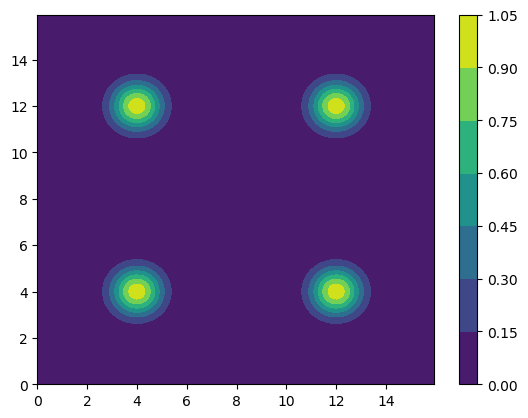

In [57]:
x″ = Δx * (0:(2*Nx-1))
y″ = Δy * (0:(2*Ny-1))
ϕs″ = vcat(hcat(ϕs, ϕs), hcat(ϕs, ϕs))
@show size(x″)
@show size(y″)
@show size(ϕs″)
PyPlot.contourf(x″, y″, ϕs″); PyPlot.colorbar();

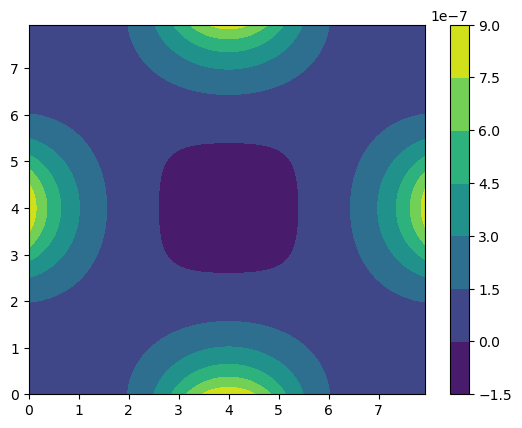

In [58]:
PyPlot.contourf(x, y, ϕs - ϕa); PyPlot.colorbar();

In [59]:
Ns = [32, 64, 128, 256, 512, 1024]
errors = []

for N in Ns
    Lx, Ly = 8, 8;
    Nx, Ny = 2*N, N
    Δx, Δy = Lx/Nx, Ly/Ny;
    x = Δx * (0:(Nx-1));
    y = Δy * (0:(Ny-1));
    
    # Primed coordinates to get a Gaussian centered at (Lx/2, Ly/2).
    x′ = @. x - Lx/2;
    y′ = @. y - Ly/2;
    
    f = @. 4 * (x′^2 + y′'^2 - 1) * exp(-(x′^2 + y′'^2))  # Source term
    f .= f .- mean(f)  # Ensure that source term integrates to zero.
    
    ϕa = @. exp(-(x′^2 + y′'^2))  # Analytic solution

    ϕs = solve_poisson_2d_pbc(f, Lx, Ly, :analytic)
    
    # Choosing the solution that integrates out to zero.
    # ϕs = ϕs .- minimum(ϕs)
    ϕs = ϕs .+ (1 - maximum(ϕs))

    @show max_error = mean(abs.(ϕs - ϕa))
    append!(errors, max_error)
end

max_error = mean(abs.(ϕs - ϕa)) = 2.2440185716619203e-7
max_error = mean(abs.(ϕs - ϕa)) = 1.9849675829731164e-7
max_error = mean(abs.(ϕs - ϕa)) = 1.917825167686224e-7
max_error = mean(abs.(ϕs - ϕa)) = 1.900879994864028e-7
max_error = mean(abs.(ϕs - ϕa)) = 1.8966334603817666e-7
max_error = mean(abs.(ϕs - ϕa)) = 1.8955711793017795e-7


size(x) = (2048,)
size(y) = 

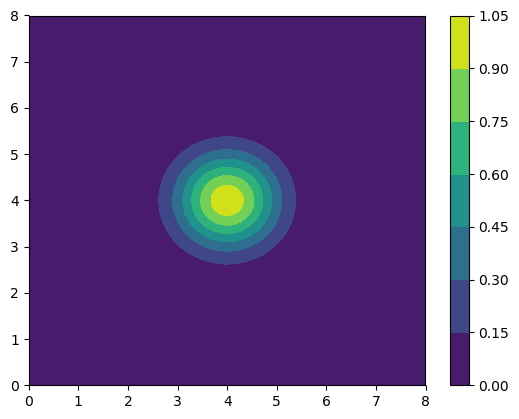

(1024,)
size(ϕs) = (2048, 1024)


In [60]:
@show size(x)
@show size(y)
@show size(ϕs)
PyPlot.contourf(y, x, ϕs); PyPlot.colorbar();
# PyPlot.loglog(Ns, errors, linestyle="--", marker="o");

In [61]:
@show minimum(ϕa)
@show maximum(ϕa)
@show minimum(ϕs)
@show maximum(ϕs)
@show 1 - maximum(ϕs)
ϕss = ϕs .+ (1 - maximum(ϕs))
@show minimum(ϕss)
@show maximum(ϕss)

minimum(ϕa) = 1.2664165549094176e-14
maximum(ϕa) = 1.0
minimum(ϕs) = 5.490275933883737e-8
maximum(ϕs) = 1.0
1 - maximum(ϕs) = 0.0
minimum(ϕss) = 5.490275933883737e-8
maximum(ϕss) = 1.0


1.0

In [62]:
laplacian2d(f) = circshift(f, (1, 0)) - 2 .* f + circshift(f, (-1, 0)) + circshift(f, (0, 1)) - 2 .* f + circshift(f, (0, -1))

laplacian2d (generic function with 1 method)

In [83]:
N = 10
A = rand(N, N)
A .= A .- mean(A)

10×10 Array{Float64,2}:
  0.0923221    0.204696   -0.152894   …   0.181885   -0.473349    0.311443
  0.0298243    0.301623    0.166081      -0.0853754   0.214173   -0.280154
 -0.472058     0.120993    0.0853811     -0.115356   -0.184534   -0.239892
 -0.0891761    0.405669    0.494336      -0.19203     0.215539    0.186876
  0.24722     -0.342915    0.409474      -0.154223   -0.0306155   0.158354
  0.0784984   -0.219825    0.384238   …   0.27245     0.250435    0.346752
  0.468206     0.150624   -0.0956268     -0.412464   -0.0762061   0.301214
  0.245967     0.119621   -0.41707       -0.478368   -0.161229   -0.122088
  0.50002      0.0915512  -0.447612      -0.0687318  -0.143746    0.387293
 -0.00467937  -0.373025   -0.450645      -0.0975156   0.334056   -0.376174

In [84]:
B = solve_poisson_2d_pbc(A, N, N, :second_order)

10×10 Array{Float64,2}:
 -0.0562155  -0.0395678   0.0971257  …   0.0821332    0.13516    -0.0324049
 -0.034399   -0.159799   -0.086699       0.0900979    0.0313533   0.0736981
  0.0345447  -0.176908   -0.148225       0.0317105    0.04063     0.0500892
 -0.172661   -0.31316    -0.316504      -0.00112889  -0.135167   -0.188408 
 -0.312799   -0.180898   -0.277183      -0.0308319   -0.17622    -0.309016 
 -0.341399   -0.163364   -0.154107   …  -0.121151    -0.260481   -0.400285 
 -0.41065    -0.196876    0.0354316      0.123214    -0.0938348  -0.34349  
 -0.29263    -0.0982979   0.200555       0.192052     0.0292123  -0.167976 
 -0.247631    0.0153812   0.333691       0.129435     0.0253794  -0.187085 
 -0.026168    0.165313    0.338582       0.0891725   -0.0137907   0.0291815

In [87]:
Ar = laplacian2d(B)

10×10 Array{Float64,2}:
  0.0923221    0.204696   -0.152894   …   0.181885   -0.473349    0.311443
  0.0298243    0.301623    0.166081      -0.0853754   0.214173   -0.280154
 -0.472058     0.120993    0.0853811     -0.115356   -0.184534   -0.239892
 -0.0891761    0.405669    0.494336      -0.19203     0.215539    0.186876
  0.24722     -0.342915    0.409474      -0.154223   -0.0306155   0.158354
  0.0784984   -0.219825    0.384238   …   0.27245     0.250435    0.346752
  0.468206     0.150624   -0.0956268     -0.412464   -0.0762061   0.301214
  0.245967     0.119621   -0.41707       -0.478368   -0.161229   -0.122088
  0.50002      0.0915512  -0.447612      -0.0687318  -0.143746    0.387293
 -0.00467937  -0.373025   -0.450645      -0.0975156   0.334056   -0.376174

In [86]:
A ≈ Ar

true

In [51]:
Nx, Ny = 8, 8

i1 = 0:Int(Nx/2)
i2 = Int(-Nx/2+1):-1
j1 = 0:Int(Ny/2)
j2 = Int(-Ny/2+1):-1

# ky = @. (2 / Δy) * sin(π*m / Ny);

kx = reshape((2/Δx) .* sin.( (π/Nx) .* cat(i1, i2, dims=1)), (Nx, 1))
ky = reshape((2/Δy) .* sin.( (π/Ny) .* cat(j1, j2, dims=1)), (1, Ny))

1×8 Array{Float64,2}:
 0.0  12.2459  22.6274  29.5641  32.0  -29.5641  -22.6274  -12.2459

In [422]:
function solve_poisson_2d_mbc(f, Lx, Ly, wavenumbers=:second_order)
    Nx, Ny = size(f)  # Number of grid points (excluding the periodic end point).

    # Forward transform the real-valued source term.
    fh = FFTW.dct(FFTW.rfft(f, 1), 2)

    # Wavenumber indices.    
    i1 = 0:Int(Nx/2)
    i2 = Int(-Nx/2+1):-1
    j1 = 0:Int(Ny/2)
    j2 = Int(-Ny/2+1):-1
    
    if wavenumbers == :second_order
        Δx = Lx/Nx
        Δy = Ly/Ny
        
        kx² = reshape((4/Δx^2) .* sin.( (π/Nx) .* cat(i1, i2, dims=1)).^2, (Nx, 1))
        # kx² = reshape((4/Δx^2) .* sin.( (π/Nx) .* 0:(Nx-1)).^2, (Nx, 1))
        
        # ky² = reshape((4/Δy^2) .* sin.( (π/(2*Ny) .* cat(j1, j2, dims=1)).^2, (1, Ny))
        # ky² = reshape((4/Δy^2) .* sin.( (π/(2*Ny) .* 0:(Ny-1)).^2, (1, Ny))
        ky² = reshape((4/Δy^2) .* sin.( (π/(2*Ny) .* 0:(Ny-1))).^2, (1, Ny))
        
        k² = @. kx² + ky²
    elseif wavenumbers == :analytic    
        kx = reshape((2π/Lx) * cat(i1, i2, dims=1), (Nx, 1))
        ky = reshape((1π/Ly) * cat(j1, j2, dims=1), (1, Ny))
        k² = @. kx^2 + ky^2
    end
        
    ϕh = - fh ./ k²[1:Int(Nx/2 + 1), :]

    # Setting the DC/zero Fourier component to zero.
    ϕh[1, 1] = 0

    # Take the inverse transform of the solution's Fourier coefficients.
    ϕ = FFTW.irfft(FFTW.idct(ϕh, 2), Nx, 1)
end

solve_poisson_2d_mbc (generic function with 2 methods)

In [415]:
horizontal_laplacian(f) = circshift(f, (1, 0)) + circshift(f, (-1, 0)) + circshift(f, (0, 1)) + circshift(f, (0, -1)) - 4 .* f

horizontal_laplacian (generic function with 1 method)

In [416]:
Nx, Ny = 6, 6
# ff = exp.(collect(1:Nx) .+ collect(1:Ny)')
ff = rand(Nx, Ny)
ff[:, 1] .= ff[:, 2]
ff[:, end] .= ff[:, end-1]
ff .= ff .- mean(ff)
ff
@show mean(ff), sum(ff);

(mean(ff), sum(ff)) = (2.4671622769447922e-17, 8.881784197001252e-16)


In [417]:
ϕr = solve_poisson_2d_mbc(ff, Nx, Ny, :second_order)

6×6 Array{Float64,2}:
 0.727778  -0.92741   -0.842973  0.910722  0.853553  -0.778432
 0.692218  -0.949497  -0.880383  0.85499   0.713173  -0.899294
 0.851998  -0.769705  -0.793929  0.843703  0.75998   -0.851745
 1.00876   -0.685243  -0.861965  1.02428   0.966226  -0.739374
 0.878764  -0.810844  -0.91846   0.888395  0.828283  -0.866655
 0.732872  -0.949989  -0.929473  0.890926  0.850727  -0.821982

In [418]:
ffr = horizontal_laplacian(ϕr)

6×6 Array{Float64,2}:
 -3.19186  1.69496  1.54535  -1.88639  -1.71802  2.97378
 -3.03789  1.91271  1.79012  -1.83274  -1.28346  3.37239
 -3.32846  1.50215  1.50737  -1.52949  -1.36856  3.38029
 -3.7289   1.30722  2.07451  -2.26078  -1.99173  3.21408
 -3.45092  1.56845  1.95995  -1.72855  -1.47444  3.61231
 -3.09692  1.8651   1.8974   -1.84333  -1.65213  3.22644

In [419]:
@. abs(ffr - ff)

6×6 Array{Float64,2}:
 3.4107   1.47613  1.61555  1.49843  1.43718  3.25463
 3.37932  1.57128  1.66972  1.4885   1.51452  3.14134
 3.17941  1.65121  1.61552  1.5666   1.63479  3.11407
 3.34259  1.69352  1.64843  1.75655  1.72431  3.4815 
 3.32996  1.68941  1.65578  1.69819  1.7019   3.38486
 3.44471  1.51731  1.62935  1.57939  1.50056  3.37801

In [420]:
@. ffr / ff

6×6 Array{Float64,2}:
 -14.586      7.74554  -22.0131     4.86227   6.11738  -10.5888
  -8.89753    5.60205   14.8675     5.32401  -5.55485   14.5958
  22.3302   -10.0777   -13.9375   -41.2141   -5.14068   12.6972
   9.65269   -3.38389    4.86875    4.48367   7.4479   -12.0188
  28.5294   -12.9667     6.4436    56.9439   -6.48234   15.8814
  -8.90445    5.36266    7.07861    6.98398  10.9002   -21.2869

In [421]:
ff ≈ ffr

false